# Introduction

The speed at which a speaker speaks can be a measurement of the quality and confidence of the speaker. If we can measure this speed, we can have a quantitative metric for grading a speakers speech. This is a difficult problem to solve using analytical methods, but possibly one that deep learning can tackle.

This project aims to predict the speaking rate (words per second) from audio data using deep learning techniques. We're using the AMI (Augmented Multi-party Interaction) dataset, which contains recordings of meetings. The dataset can be found here: https://huggingface.co/datasets/edinburghcstr/ami. This dataset contains 109,682 audio files, totaling 11.5 GB.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import seaborn as sns

In [2]:
np.__version__

'1.26.4'

# EDA

In this crucial phase, we dive deep into understanding our dataset. The AMI dataset provides us with audio samples and corresponding transcriptions. Our goal is to extract meaningful insights that will inform our model design and data preprocessing steps.

In [3]:
dataset = load_dataset("edinburghcstr/ami", "ihm", trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

We can see that the data contains:
- Text, this will be useful in getting total number of words
- audio, this will be the input to our model
- begin_time
- end_time

In [4]:
dataset['train'][0]

{'meeting_id': 'EN2001a',
 'audio_id': 'AMI_EN2001a_H04_MEO069_0330297_0330718',
 'text': 'IF YOU IF YOU S. S. H. AND THEY HAVE THIS BIG WARNING ABOUT DOING NOTHING AT ALL IN THE GATEWAY MACHINE',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/b093dd855ad7f053bb12157f9ce4b51aaeaf29ccaf78fdc8150b3a8125130e2b/EN2001a/train_ami_en2001a_h04_meo069_0330297_0330718.wav',
  'array': array([ 0.00231934, -0.00183105, -0.00543213, ..., -0.00238037,
         -0.00244141, -0.00219727]),
  'sampling_rate': 16000},
 'begin_time': 3302.969970703125,
 'end_time': 3307.179931640625,
 'microphone_id': 'H04',
 'speaker_id': 'MEO069'}

## Loading and Visualizing the Data

We start by loading the AMI dataset using the datasets library. We then visualize a couple of audio samples to get a feel for the data we're working with. This visualization helps us understand the structure and potential patterns in the audio signals.

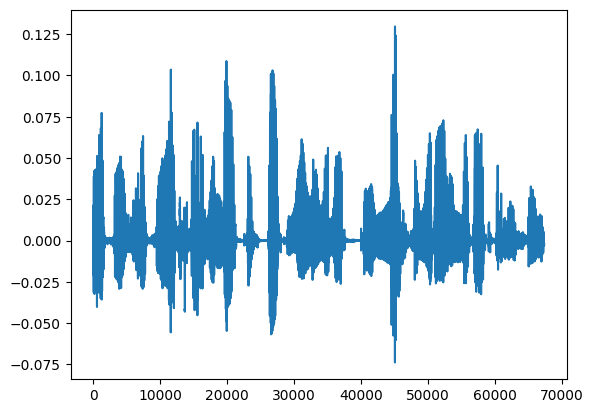

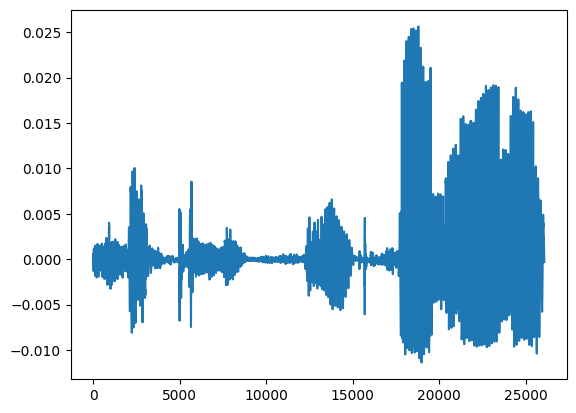

In [5]:
audio_sample = dataset['train'][0]['audio']['array']
fig, ax = plt.subplots()
ax.plot(audio_sample)
fig.show()

audio_sample = dataset['train'][1]['audio']['array']
fig, ax = plt.subplots()
ax.plot(audio_sample)
fig.show()

In [6]:
len(dataset['train'])


108502

In [7]:
def transform_dataset(dataset, limit, category='train'):
    data = {'audio': [], 'wps': []}
    for i in range(limit):
        row_data = dataset[category][i]
        audio_data = row_data['audio']['array']
        word_count = len(row_data['text'].split())
        speech_time = row_data['end_time'] - row_data['begin_time']
        words_per_second = (word_count / speech_time)
        data['audio'].append(audio_data)
        data['wps'].append(words_per_second)
    return data

In [8]:
reduced_dataset = transform_dataset(dataset, 20_000, category='train')

In [9]:
df = pd.DataFrame(reduced_dataset)
df

,audio,wps
0,"[0.0023193359375, -0.0018310546875, -0.0054321...",5.225702
1,"[-0.000518798828125, 0.0001220703125, 0.000122...",3.067705
2,"[-0.000152587890625, -0.000213623046875, -0.00...",2.857143
3,"[0.0, 0.0, 6.103515625e-05, 3.0517578125e-05, ...",3.139720
4,"[-0.001495361328125, -0.001495361328125, -0.00...",2.701847
...,...,...
19995,"[-3.0517578125e-05, -3.0517578125e-05, 0.0, 3....",3.881720
19996,"[-0.0057373046875, -0.005401611328125, -0.0046...",2.564006
19997,"[-0.00738525390625, -0.007354736328125, -0.007...",2.524542
19998,"[0.0, -3.0517578125e-05, 0.0, 0.0, 0.0, 0.0, 0...",3.242329


A key aspect of our project is understanding the distribution of speaking rates. We calculate words per second for each audio sample and visualize this distribution using a kernel density estimation plot. This analysis reveals:

- The range of speaking rates in our dataset
- Potential outliers or unrealistic values
- The central tendency and spread of speaking rates

Based on our findings, we clean the data by removing samples with unrealistically high speaking rates (above 10 words per second). This step ensures our model trains on more reliable data.

Words Per Second mean:  3.2820695477180153
Words Per Second max:  49.951219512195124
Words Per Second min:  0.04638219449154821


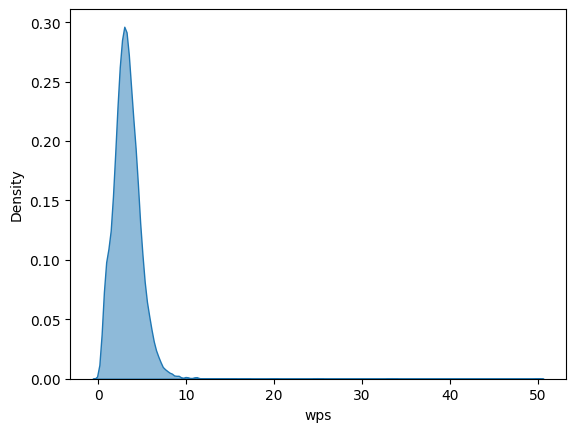

In [10]:
sns.kdeplot(data=df, x='wps', fill=True, alpha=0.5)
print("Words Per Second mean: ", df['wps'].mean())
print("Words Per Second max: ", df['wps'].max())
print("Words Per Second min: ", df['wps'].min())

49 words per second seems odd, even for an auctioneer. I'm going to drop anything above 10 words per second, as that seems unrealistic

In [11]:
df = df.loc[df['wps'] < 10.0]

Words Per Second mean:  3.2398732894205735
Words Per Second max:  9.990243902439024
Words Per Second min:  0.04638219449154821


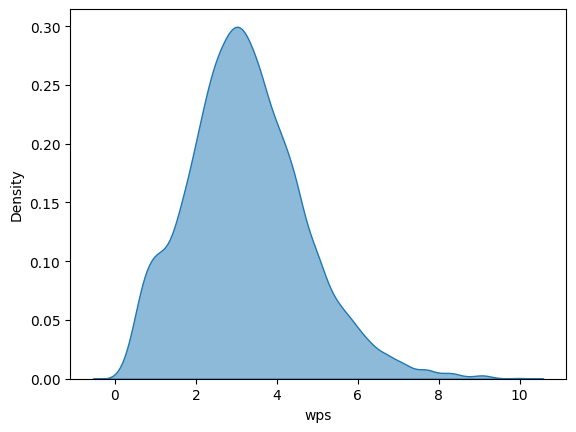

In [12]:

sns.kdeplot(data=df, x='wps', fill=True, alpha=0.5)
print("Words Per Second mean: ", df['wps'].mean())
print("Words Per Second max: ", df['wps'].max())
print("Words Per Second min: ", df['wps'].min())

10 words per second is probably still a little too high, but we will leave it in there. Our mean moved slightly to the left when we dropped those high values, which is expected.

## Normalization

Data normalization is crucial for effective neural network training. We apply two types of normalization:

Words per second normalization: We scale the WPS values to a 0-1 range, which is a common practice for regression tasks.
Audio normalization: We apply Root Mean Square (RMS) normalization to standardize the volume levels across all audio samples.

These normalization steps help in creating a consistent scale across our features and target variable, potentially leading to faster convergence during training.

In [13]:
# Words per second normalization
# We know that words per second range from 0-10 so we can simply divide by 10 to min-max normalize to 0-1
df['wps'] = df['wps'] / 10.0

<ipython-input-13-59bdb3155e9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wps'] = df['wps'] / 10.0


In [14]:
# Audio normalization

def rms_normalization(arr, target_rms):
    current_rms = np.sqrt(np.mean(np.square(arr)))
    scaling_factor = target_rms / current_rms if current_rms > 0 else 1
    return arr * scaling_factor

df['audio'] = df['audio'].apply(lambda x: rms_normalization(x, 0.1))

<ipython-input-14-8ea56053940c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audio'] = df['audio'].apply(lambda x: rms_normalization(x, 0.1))


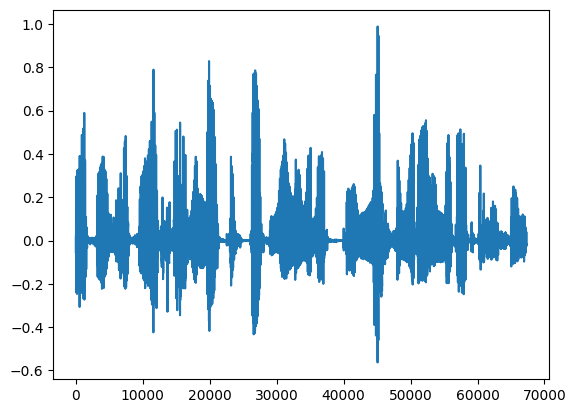

In [15]:

audio_sample = df['audio'].iloc[0]
fig, ax = plt.subplots()
ax.plot(audio_sample)
fig.show()

## Audio Chunking
To address the issue of very long sequences (around 70,000 points), we implement an audio chunking strategy. This involves:

- Dividing the audio into smaller, overlapping chunks
- Reducing the sequence length while retaining temporal information
- Creating a more manageable input size for our LSTM/GRU models

We visualize the distribution of original sequence lengths and chunked lengths to demonstrate the effect of this preprocessing step.

In [16]:
def chunk_audio(audio, frame_length, frame_step):
    if len(audio) < frame_length:
        return np.array([])
    frames = []
    for start in range(0, len(audio) - frame_length + 1, frame_step):
        frames.append(audio[start:start+frame_length])
    return np.array(frames)

In [17]:
frame_length = 400
frame_step = 100

df['chunked_audio'] = df['audio'].apply(lambda x: chunk_audio(x, frame_length, frame_step))

df['chunked_audio']

<ipython-input-17-af300d73ca9e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunked_audio'] = df['audio'].apply(lambda x: chunk_audio(x, frame_length, frame_step))


,chunked_audio
0,"[[0.017672978309104366, -0.013952351296661343,..."
1,"[[-0.012651380207559173, 0.0029767953429550996..."
2,"[[-0.003878186112444303, -0.005429460557422024..."
3,"[[0.0, 0.0, 0.0003031234703964115, 0.000151561..."
4,"[[-0.03916168411249802, -0.03916168411249802, ..."
...,...
19995,"[[-0.00013735442384306756, -0.0001373544238430..."
19996,"[[-0.1537216787065081, -0.14472732516516984, -..."
19997,"[[-0.048657529702691195, -0.048456465530366026..."
19998,"[[0.0, -0.0001455832576821084, 0.0, 0.0, 0.0, ..."


In [18]:
df['sequence_length'] = df['audio'].apply(lambda x: len(x))
df['chunked_length'] = df['chunked_audio'].apply(lambda x: len(x))


<ipython-input-18-de8da1d8c79d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_length'] = df['audio'].apply(lambda x: len(x))
<ipython-input-18-de8da1d8c79d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunked_length'] = df['chunked_audio'].apply(lambda x: len(x))


Text(0, 0.5, 'Frequency')

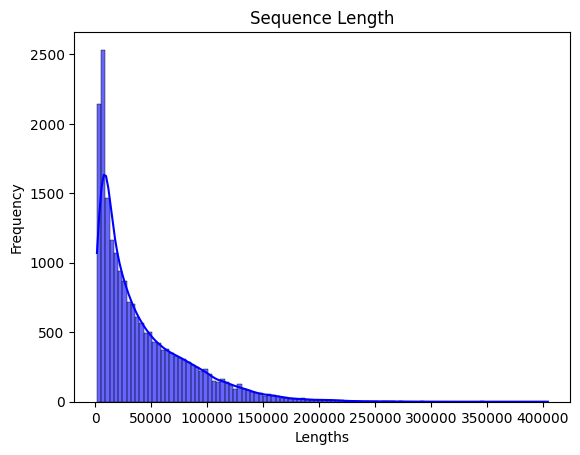

In [19]:

sns.histplot(data=df, x='sequence_length', kde=True, color="blue", label='sequence_length', alpha=0.6)
plt.title('Sequence Length')
plt.xlabel('Lengths')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

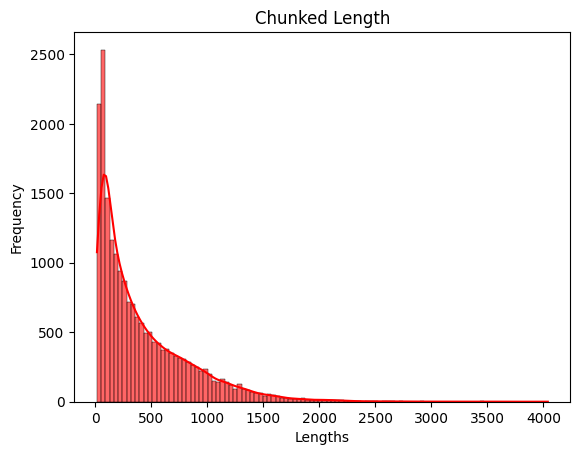

In [20]:

sns.histplot(data=df, x='chunked_length', kde=True, color="red", label='chunked_length', alpha=0.6)
plt.title('Chunked Length')
plt.xlabel('Lengths')
plt.ylabel('Frequency')

By chunking our dataset, we can move elements of our audio 'horizontally' and reduce our overall sequence length. This will help improve the performance of the LSTM by having a smaller context window to work with

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset and DataLoader Preparation
Proper data handling is crucial for efficient model training. We create custom PyTorch classes and functions to prepare our data:
## Custom Dataset Class
We implement a SpeechDataset class that inherits from PyTorch's Dataset. This class:

Holds our preprocessed audio data and corresponding WPS values
Defines how individual samples are accessed and returned

## Collate Function
To handle variable-length sequences in our batches, we implement a custom collate_fn. This function:

Pads shorter sequences to match the length of the longest sequence in the batch
Returns padded sequences along with their original lengths (crucial for proper LSTM/GRU processing)

## DataLoader Setup
We create separate DataLoaders for training and validation sets, incorporating our custom dataset and collate function. This setup enables efficient batching and shuffling of our data during training.

In [22]:
class SpeechDataset(Dataset):
    def __init__(self, audio_data):
        self.audio_data = audio_data

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        audio_data = self.audio_data.iloc[idx]
        audio = torch.FloatTensor(audio_data['chunked_audio'])
        words_per_second = torch.FloatTensor([audio_data['wps']])
        return audio, words_per_second


In [23]:
def collate_fn(batch):
    batch = [(audio, count) for audio, count in batch if audio.numel() > 0]
    if len(batch) == 0:
        return torch.tensor([]),  torch.tensor([]), torch.tensor([])
    audios, word_counts = zip(*batch)
    lengths = [audio.shape[0] for audio in audios]
    padded_audios = pad_sequence(audios, batch_first=True)
    return padded_audios, torch.tensor(word_counts), torch.tensor(lengths)


# Model Architecture
We explore two types of recurrent neural networks for our task:
1. LSTM
2. GRU

## LSTM Model
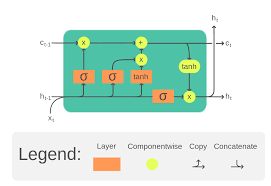

image credit to: https://en.wikipedia.org/wiki/Long_short-term_memory

The Long Short-Term Memory (LSTM) model  performs similarily to the RNN model, however it adds a cell state and gates. The sell state contains information that can be seen throughout the sequence. The gates regulate information flow and are comprised of a forget gate, an input gate and an output gate. The forget gate desides what information to discard from the cell state. The input gate determines what new information to store in the cell state. The output gate decides what to output based on the cell state. Like the RNN the result of this sequence is passed to a linear layer for classification


LSTM networks are well-suited for processing sequential data like audio. Our WordCountLSTM class includes:

- LSTM layers for capturing temporal dependencies
- Fully connected layers for final prediction


In [24]:
class WordCountLSTM(nn.Module):
    def __init__(self, input_size, num_lstm_layers=2, hidden_size=64, num_hidden_layers=1):
        super(WordCountLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_lstm_layers, batch_first=True)
        # Build FC layers
        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if i > 0:
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed_x)
        output = self.fc_layers((hidden[-1]))
        return output.squeeze(1)

## GRU Model
![GRU Model](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/220px-Gated_Recurrent_Unit%2C_base_type.svg.png)

Image credit to: https://en.wikipedia.org/wiki/Gated_recurrent_unit
We also implement a Gated Recurrent Unit (GRU) model as an alternative to LSTM. GRUs are similar to LSTMs but with a simpler structure, potentially leading to faster training. A GRU only contains an update gate, and a reset gate. An update gates simply decides what information to keep. A Reset gate determines how much information to forget.



In [25]:

class WordCountGRU(nn.Module):
    def __init__(self, input_size, num_lstm_layers=2, hidden_size=64, num_hidden_layers=1):
        super(WordCountGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_lstm_layers, batch_first=True)
        # Build FC layers
        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if i > 0:
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.gru(packed_x)
        output = self.fc_layers((hidden[-1]))
        return output.squeeze(1)


In [26]:
train_dataset = SpeechDataset(df.iloc[:18000])
val_dataset = SpeechDataset(df.iloc[18000:])
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:

word_count_lstm = WordCountLSTM(400)

# Training Process



In [27]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for audio, wps, lengths in data_loader:
            if audio.numel() == 0:
                continue
            audio = audio.to(device)
            wps = wps.to(device)
            lengths = lengths.to(device)
            outputs = model(audio, lengths)
            loss = criterion(outputs, wps.float())
            total_loss += loss.item()
    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, criterion,  optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        for audio, wps, lengths in tqdm(train_loader):
            if audio.numel() == 0:
                continue
            audio = audio.to(device)
            wps = wps.to(device)
            lengths = lengths.to(device)
            optimizer.zero_grad()
            outputs = model(audio, lengths)
            loss = criterion(outputs, wps.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    return train_losses, val_losses


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(word_count_lstm.parameters(), lr=0.0001)
num_epochs = 10
word_count_lstm.to(device)

WordCountLSTM(
  (lstm): LSTM(400, 64, num_layers=2, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
train_losses, val_losses = train_model(word_count_lstm, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

100%|██████████| 157/157 [00:39<00:00,  3.99it/s]


Epoch 1/10, Loss: 0.0537, Val Loss: 0.0267


100%|██████████| 157/157 [00:37<00:00,  4.16it/s]


Epoch 2/10, Loss: 0.0186, Val Loss: 0.0262


100%|██████████| 157/157 [00:37<00:00,  4.16it/s]


Epoch 3/10, Loss: 0.0183, Val Loss: 0.0261


100%|██████████| 157/157 [00:38<00:00,  4.11it/s]


Epoch 4/10, Loss: 0.0180, Val Loss: 0.0259


100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


Epoch 5/10, Loss: 0.0178, Val Loss: 0.0258


100%|██████████| 157/157 [00:38<00:00,  4.06it/s]


Epoch 6/10, Loss: 0.0177, Val Loss: 0.0255


100%|██████████| 157/157 [00:38<00:00,  4.07it/s]


Epoch 7/10, Loss: 0.0176, Val Loss: 0.0254


100%|██████████| 157/157 [00:38<00:00,  4.06it/s]


Epoch 8/10, Loss: 0.0175, Val Loss: 0.0254


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]


Epoch 9/10, Loss: 0.0173, Val Loss: 0.0250


100%|██████████| 157/157 [00:38<00:00,  4.12it/s]


Epoch 10/10, Loss: 0.0171, Val Loss: 0.0246


In [ ]:
torch.save(word_count_lstm.state_dict(), 'word_count_lstm.pt')

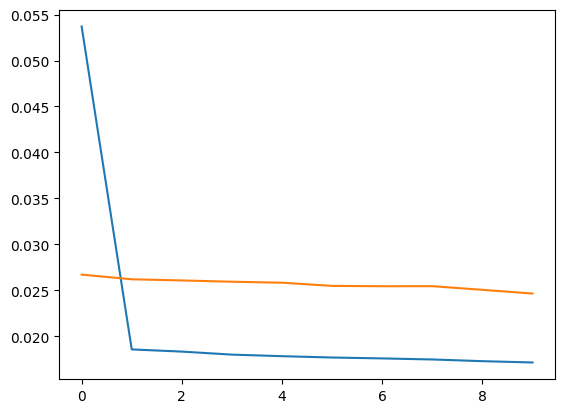

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses)
ax.plot(val_losses)
fig.show()

In [ ]:
word_count_gru = WordCountGRU(400)

criterion = nn.MSELoss()
optimizer = optim.Adam(word_count_gru.parameters(), lr=0.0001)
num_epochs = 10
word_count_gru.to(device)

WordCountGRU(
  (gru): GRU(400, 64, num_layers=2, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
gru_train_losses, gru_val_losses = train_model(word_count_gru, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

100%|██████████| 157/157 [00:39<00:00,  3.97it/s]


Epoch 1/10, Loss: 0.0273, Val Loss: 0.0266


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 2/10, Loss: 0.0187, Val Loss: 0.0265


100%|██████████| 157/157 [00:39<00:00,  3.99it/s]


Epoch 3/10, Loss: 0.0184, Val Loss: 0.0261


100%|██████████| 157/157 [00:39<00:00,  4.01it/s]


Epoch 4/10, Loss: 0.0183, Val Loss: 0.0260


100%|██████████| 157/157 [00:39<00:00,  4.01it/s]


Epoch 5/10, Loss: 0.0179, Val Loss: 0.0259


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]


Epoch 6/10, Loss: 0.0179, Val Loss: 0.0257


100%|██████████| 157/157 [00:38<00:00,  4.10it/s]


Epoch 7/10, Loss: 0.0177, Val Loss: 0.0259


100%|██████████| 157/157 [00:38<00:00,  4.06it/s]


Epoch 8/10, Loss: 0.0176, Val Loss: 0.0254


100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


Epoch 9/10, Loss: 0.0175, Val Loss: 0.0253


100%|██████████| 157/157 [00:37<00:00,  4.14it/s]


Epoch 10/10, Loss: 0.0173, Val Loss: 0.0251


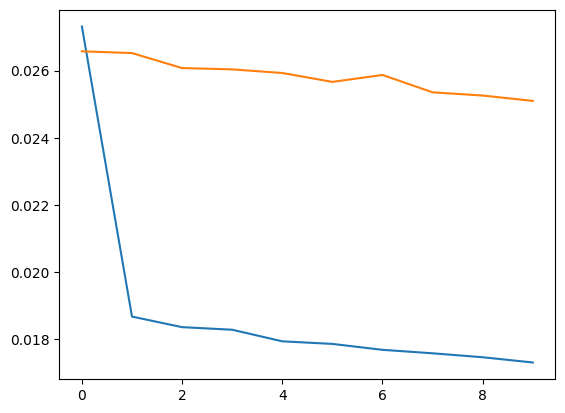

In [ ]:

fig, ax = plt.subplots()
ax.plot(gru_train_losses)
ax.plot(gru_val_losses)
fig.show()

In [ ]:


import itertools
from sklearn.model_selection import ParameterGrid



In [ ]:
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader):
  n_epochs = 5
  loss = train_model(model, train_loader, val_loader, criterion,optimizer , n_epochs)
  return loss[1][-1]

def grid_search(model_class, param_grid, train_loader, val_loader):
  results = []
  for params in ParameterGrid(param_grid):
    model = model_class(400, num_lstm_layers=params['lstm_layers'], hidden_size=params['hidden_size'], num_hidden_layers=params['hidden_layers'])
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    val_accuracy = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    results.append({**params, 'val_loss': val_accuracy})

  return results

In [ ]:


param_grid = {
    'lstm_layers': [1, 2],
    'hidden_size': [32, 64, 128],
    'hidden_layers': [2, 3],
}
lstm_parameter_results = grid_search(WordCountLSTM, param_grid, train_dataloader, val_dataloader)



100%|██████████| 157/157 [00:32<00:00,  4.85it/s]


Epoch 1/5, Loss: 0.0303, Val Loss: 0.0269


100%|██████████| 157/157 [00:31<00:00,  4.95it/s]


Epoch 2/5, Loss: 0.0188, Val Loss: 0.0266


100%|██████████| 157/157 [00:31<00:00,  5.04it/s]


Epoch 3/5, Loss: 0.0187, Val Loss: 0.0268


100%|██████████| 157/157 [00:31<00:00,  4.95it/s]


Epoch 4/5, Loss: 0.0184, Val Loss: 0.0263


100%|██████████| 157/157 [00:31<00:00,  4.98it/s]


Epoch 5/5, Loss: 0.0179, Val Loss: 0.0257


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]


Epoch 1/5, Loss: 0.0822, Val Loss: 0.0273


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0265


100%|██████████| 157/157 [00:38<00:00,  4.11it/s]


Epoch 3/5, Loss: 0.0184, Val Loss: 0.0259


100%|██████████| 157/157 [00:38<00:00,  4.10it/s]


Epoch 4/5, Loss: 0.0180, Val Loss: 0.0255


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 5/5, Loss: 0.0177, Val Loss: 0.0253


100%|██████████| 157/157 [00:32<00:00,  4.79it/s]


Epoch 1/5, Loss: 0.0356, Val Loss: 0.0265


100%|██████████| 157/157 [00:31<00:00,  5.00it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0264


100%|██████████| 157/157 [00:32<00:00,  4.87it/s]


Epoch 3/5, Loss: 0.0183, Val Loss: 0.0263


100%|██████████| 157/157 [00:31<00:00,  4.97it/s]


Epoch 4/5, Loss: 0.0180, Val Loss: 0.0260


100%|██████████| 157/157 [00:31<00:00,  4.98it/s]


Epoch 5/5, Loss: 0.0177, Val Loss: 0.0257


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 1/5, Loss: 0.0292, Val Loss: 0.0266


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 2/5, Loss: 0.0188, Val Loss: 0.0264


100%|██████████| 157/157 [00:39<00:00,  4.00it/s]


Epoch 3/5, Loss: 0.0185, Val Loss: 0.0260


100%|██████████| 157/157 [00:39<00:00,  3.97it/s]


Epoch 4/5, Loss: 0.0180, Val Loss: 0.0255


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 5/5, Loss: 0.0175, Val Loss: 0.0250


100%|██████████| 157/157 [00:33<00:00,  4.68it/s]


Epoch 1/5, Loss: 0.0345, Val Loss: 0.0270


100%|██████████| 157/157 [00:33<00:00,  4.70it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0267


100%|██████████| 157/157 [00:33<00:00,  4.73it/s]


Epoch 3/5, Loss: 0.0184, Val Loss: 0.0261


100%|██████████| 157/157 [00:32<00:00,  4.81it/s]


Epoch 4/5, Loss: 0.0180, Val Loss: 0.0260


100%|██████████| 157/157 [00:33<00:00,  4.69it/s]


Epoch 5/5, Loss: 0.0179, Val Loss: 0.0256


100%|██████████| 157/157 [00:41<00:00,  3.78it/s]


Epoch 1/5, Loss: 0.0450, Val Loss: 0.0265


100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0267


100%|██████████| 157/157 [00:39<00:00,  3.94it/s]


Epoch 3/5, Loss: 0.0183, Val Loss: 0.0261


100%|██████████| 157/157 [00:40<00:00,  3.91it/s]


Epoch 4/5, Loss: 0.0179, Val Loss: 0.0255


100%|██████████| 157/157 [00:40<00:00,  3.86it/s]


Epoch 5/5, Loss: 0.0177, Val Loss: 0.0252


100%|██████████| 157/157 [00:32<00:00,  4.88it/s]


Epoch 1/5, Loss: 0.0822, Val Loss: 0.0322


100%|██████████| 157/157 [00:32<00:00,  4.86it/s]


Epoch 2/5, Loss: 0.0193, Val Loss: 0.0266


100%|██████████| 157/157 [00:31<00:00,  4.98it/s]


Epoch 3/5, Loss: 0.0185, Val Loss: 0.0264


100%|██████████| 157/157 [00:31<00:00,  4.99it/s]


Epoch 4/5, Loss: 0.0182, Val Loss: 0.0262


100%|██████████| 157/157 [00:31<00:00,  4.95it/s]


Epoch 5/5, Loss: 0.0178, Val Loss: 0.0255


100%|██████████| 157/157 [00:39<00:00,  3.96it/s]


Epoch 1/5, Loss: 0.1783, Val Loss: 0.0880


100%|██████████| 157/157 [00:39<00:00,  4.00it/s]


Epoch 2/5, Loss: 0.0258, Val Loss: 0.0267


100%|██████████| 157/157 [00:39<00:00,  4.01it/s]


Epoch 3/5, Loss: 0.0188, Val Loss: 0.0265


100%|██████████| 157/157 [00:38<00:00,  4.10it/s]


Epoch 4/5, Loss: 0.0184, Val Loss: 0.0263


100%|██████████| 157/157 [00:38<00:00,  4.08it/s]


Epoch 5/5, Loss: 0.0180, Val Loss: 0.0257


100%|██████████| 157/157 [00:32<00:00,  4.90it/s]


Epoch 1/5, Loss: 0.0352, Val Loss: 0.0266


100%|██████████| 157/157 [00:31<00:00,  4.95it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0264


100%|██████████| 157/157 [00:31<00:00,  4.93it/s]


Epoch 3/5, Loss: 0.0184, Val Loss: 0.0260


100%|██████████| 157/157 [00:31<00:00,  4.99it/s]


Epoch 4/5, Loss: 0.0180, Val Loss: 0.0256


100%|██████████| 157/157 [00:31<00:00,  4.93it/s]


Epoch 5/5, Loss: 0.0177, Val Loss: 0.0255


100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Epoch 1/5, Loss: 0.0408, Val Loss: 0.0271


100%|██████████| 157/157 [00:38<00:00,  4.05it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0264


100%|██████████| 157/157 [00:38<00:00,  4.08it/s]


Epoch 3/5, Loss: 0.0183, Val Loss: 0.0258


100%|██████████| 157/157 [00:38<00:00,  4.03it/s]


Epoch 4/5, Loss: 0.0179, Val Loss: 0.0255


100%|██████████| 157/157 [00:38<00:00,  4.07it/s]


Epoch 5/5, Loss: 0.0175, Val Loss: 0.0255


100%|██████████| 157/157 [00:33<00:00,  4.73it/s]


Epoch 1/5, Loss: 0.0462, Val Loss: 0.0266


100%|██████████| 157/157 [00:32<00:00,  4.77it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0264


100%|██████████| 157/157 [00:33<00:00,  4.72it/s]


Epoch 3/5, Loss: 0.0184, Val Loss: 0.0266


100%|██████████| 157/157 [00:33<00:00,  4.74it/s]


Epoch 4/5, Loss: 0.0182, Val Loss: 0.0262


100%|██████████| 157/157 [00:32<00:00,  4.84it/s]


Epoch 5/5, Loss: 0.0179, Val Loss: 0.0258


100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch 1/5, Loss: 0.0356, Val Loss: 0.0266


100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch 2/5, Loss: 0.0187, Val Loss: 0.0263


100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch 3/5, Loss: 0.0183, Val Loss: 0.0257


100%|██████████| 157/157 [00:40<00:00,  3.86it/s]


Epoch 4/5, Loss: 0.0179, Val Loss: 0.0255


100%|██████████| 157/157 [00:40<00:00,  3.91it/s]


Epoch 5/5, Loss: 0.0174, Val Loss: 0.0246


In [ ]:
best_lstm_param = sorted(lstm_parameter_results, key=lambda x: x['val_loss'])[0]
print(best_lstm_param)

{'hidden_layers': 3, 'hidden_size': 128, 'lstm_layers': 2, 'val_loss': 0.024592765396641146}


In [28]:
best_lstm_param = {'hidden_layers': 3, 'hidden_size': 128, 'lstm_layers': 2}

# Initialize the model
model = WordCountLSTM(400, num_lstm_layers=best_lstm_param['lstm_layers'], hidden_size=best_lstm_param['hidden_size'], num_hidden_layers=best_lstm_param['hidden_layers'])
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
epochs = 20
losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs)



100%|██████████| 282/282 [01:01<00:00,  4.62it/s]


Epoch 1/20, Loss: 0.0255, Val Loss: 0.0213


100%|██████████| 282/282 [00:59<00:00,  4.72it/s]


Epoch 2/20, Loss: 0.0190, Val Loss: 0.0186


100%|██████████| 282/282 [00:59<00:00,  4.75it/s]


Epoch 3/20, Loss: 0.0178, Val Loss: 0.0168


100%|██████████| 282/282 [00:59<00:00,  4.71it/s]


Epoch 4/20, Loss: 0.0166, Val Loss: 0.0156


100%|██████████| 282/282 [00:59<00:00,  4.73it/s]


Epoch 5/20, Loss: 0.0166, Val Loss: 0.0173


100%|██████████| 282/282 [01:00<00:00,  4.69it/s]


Epoch 6/20, Loss: 0.0189, Val Loss: 0.0169


100%|██████████| 282/282 [01:00<00:00,  4.63it/s]


Epoch 7/20, Loss: 0.0186, Val Loss: 0.0168


100%|██████████| 282/282 [01:00<00:00,  4.66it/s]


Epoch 8/20, Loss: 0.0181, Val Loss: 0.0163


100%|██████████| 282/282 [01:00<00:00,  4.67it/s]


Epoch 9/20, Loss: 0.0175, Val Loss: 0.0152


100%|██████████| 282/282 [01:00<00:00,  4.63it/s]


Epoch 10/20, Loss: 0.0155, Val Loss: 0.0144


100%|██████████| 282/282 [01:00<00:00,  4.64it/s]


Epoch 11/20, Loss: 0.0149, Val Loss: 0.0131


100%|██████████| 282/282 [00:59<00:00,  4.72it/s]


Epoch 12/20, Loss: 0.0147, Val Loss: 0.0159


100%|██████████| 282/282 [00:59<00:00,  4.71it/s]


Epoch 13/20, Loss: 0.0160, Val Loss: 0.0129


100%|██████████| 282/282 [00:59<00:00,  4.75it/s]


Epoch 14/20, Loss: 0.0134, Val Loss: 0.0129


100%|██████████| 282/282 [01:00<00:00,  4.68it/s]


Epoch 15/20, Loss: 0.0130, Val Loss: 0.0125


100%|██████████| 282/282 [01:00<00:00,  4.68it/s]


Epoch 16/20, Loss: 0.0124, Val Loss: 0.0120


100%|██████████| 282/282 [01:00<00:00,  4.70it/s]


Epoch 17/20, Loss: 0.0120, Val Loss: 0.0113


100%|██████████| 282/282 [00:59<00:00,  4.70it/s]


Epoch 18/20, Loss: 0.0110, Val Loss: 0.0104


100%|██████████| 282/282 [01:00<00:00,  4.67it/s]


Epoch 19/20, Loss: 0.0106, Val Loss: 0.0099


100%|██████████| 282/282 [01:00<00:00,  4.67it/s]


Epoch 20/20, Loss: 0.0100, Val Loss: 0.0106


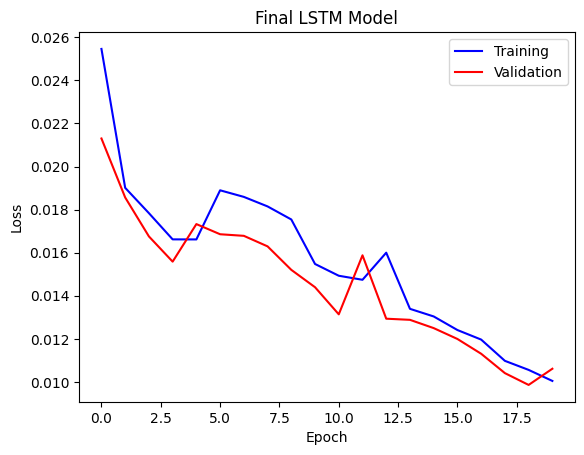

In [29]:


fig, ax = plt.subplots()
ax.plot(losses[0], 'b-', label='Training')
ax.plot(losses[1], 'r-', label='Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Final LSTM Model')
fig.show()



In [30]:
torch.save(model.state_dict(), 'best_lstm.pt')

# Results

Now that we have tuned and trained the LSTM model. We will see how its predictions actually look in terms of words per second.

In [31]:
def test_model(model, data_loader):
    model.eval()
    diffs = []
    predictions = []
    truth = []
    with torch.no_grad():
        for audio, wps, lengths in data_loader:
            if audio.numel() == 0:
                continue
            audio = audio.to(device)
            wps = wps.to(device)
            lengths = lengths.to(device)
            outputs = model(audio, lengths)
            diff = torch.abs(outputs - wps.float()).detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            wps = wps.detach().cpu().numpy()
            for d, out, w in zip(diff, outputs, wps):
                diffs.append(d)
                predictions.append(out)
                truth.append(w)
    return np.array(diffs) * 10.0, np.array(predictions) * 10.0, np.array(truth) * 10.0

In [32]:
diffs, predictions, truth = test_model(model, val_dataloader)
data = {'WPS Difference': diffs, 'Predictions': predictions, 'Truth': truth}
out_df = pd.DataFrame(data)




Predicted Mean:  3.0886095 | Truth Mean:  3.2151244
Predicted Max:  9.750626 | Truth Max:  9.413387
Predicted Min:  0.9788028 | Truth Min:  0.3367002


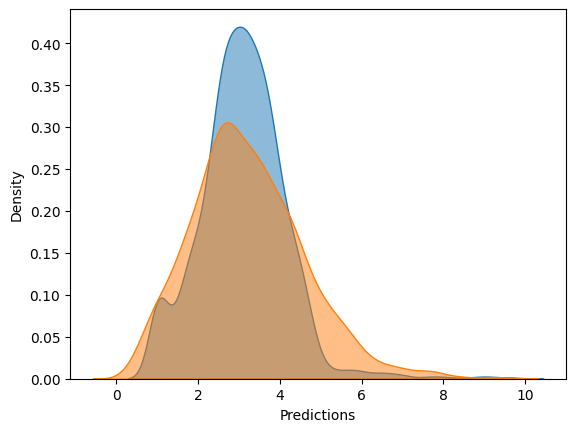

In [33]:
sns.kdeplot(data=out_df, x='Predictions', fill=True, alpha=0.5)
sns.kdeplot(data=out_df, x='Truth', fill=True, alpha=0.5)
print("Predicted Mean: ", out_df['Predictions'].mean(), '| Truth Mean: ', out_df['Truth'].mean())
print("Predicted Max: ", out_df['Predictions'].max(), '| Truth Max: ', out_df['Truth'].max())
print("Predicted Min: ", out_df['Predictions'].min(), '| Truth Min: ', out_df['Truth'].min())


Words Per Second mean:  0.74050784
Words Per Second max:  6.859975
Words Per Second min:  0.00019609928


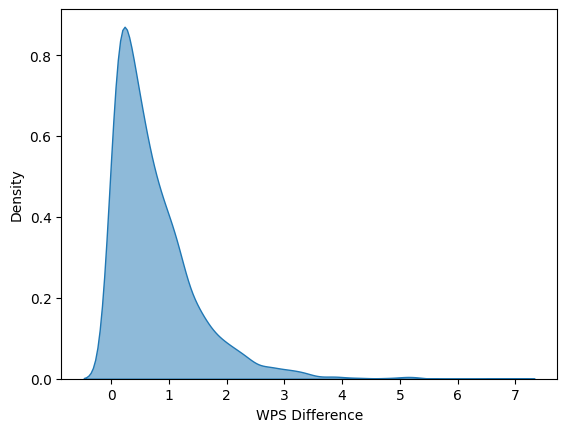

In [34]:
sns.kdeplot(data=out_df, x='WPS Difference', fill=True, alpha=0.5)
print("Words Per Second mean: ", out_df['WPS Difference'].mean())
print("Words Per Second max: ", out_df['WPS Difference'].max())
print("Words Per Second min: ", out_df['WPS Difference'].min())

# Conclusion

In this project we have predicted words per second in a given audio file containing a person speaking. We have acomplished this by looking at:
- Audio data transfomations
    - Chunking
    - RMS Normalization
- Modeling
    - LSTM Model
    - GRU Model
- Hyperparameter tuning
    - Found optimal LSTM Model

We created a model that is 0.74 words per second off on average when predicting the words per second in a speech! I still think this can be improved by trying:
- Different data transformations
  - Mel Spectograms have shown promising results. This is where we would place the audio data into a 2D structure and use something like a CNN on it
- More exhaustive hyper paramater tuning
  - We only performed a grid search, and that search found parameters that were at the upper bound of search. This suggests expanding and refining our search space could yield better results
- Train with more data
  - We limited the data used during training to address memory limitations. A better data loading structure could reduce the amount we hold in memory and allow for training on more samples.